# Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Applied AI in Biomed/

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1m33L_-cg9GGaF5w8ZpdMxLGX7wutvAV5/Applied AI in Biomed


In [ ]:
!pip install pynrrd
!pip install openpyxl
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 23.0 MB/s eta 0:00:00


In [ ]:
import os
import random
import warnings
import logging

import numpy as np
import pandas as pd
import nrrd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import seaborn as sns
from xml.dom import minidom
from concurrent.futures import ThreadPoolExecutor
import scipy
from PIL import Image
from skimage import morphology
from skimage.transform import resize
from tqdm import tqdm

# Set seed for reproducibility
seed = 42

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Set seeds for random number generators
np.random.seed(seed)
random.seed(seed)

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# Exploratory Data Analysis

## Data Statistics

Single image

In [ ]:
# Function to load and analyze a .nrrd image
def analyze_nrrd_image(image_path):
    try:
        # Load the .nrrd image
        image_data, header = nrrd.read(image_path)

        # Calculate statistics
        dimensions = image_data.shape
        dtype = image_data.dtype
        min_val = np.min(image_data)
        max_val = np.max(image_data)
        mean_val = np.mean(image_data)
        std_val = np.std(image_data)

        # Print statistics
        print(f"File: {os.path.basename(image_path)}")
        print(f"Dimensions: {dimensions}")
        print(f"Data Type: {dtype}")
        print(f"Min Value: {min_val}")
        print(f"Max Value: {max_val}")
        print(f"Mean Value: {mean_val:.2f}")
        print(f"Standard Deviation: {std_val:.2f}")
        print(f"Header Info: {header}")

    except Exception as e:
        print(f"Error loading image: {e}")

# Analyze the image
analyze_nrrd_image('Train/pat7_fullslice.nrrd')
analyze_nrrd_image('Train/pat7_nodule.nrrd')

File: pat7_fullslice.nrrd
Dimensions: (512, 512)
Data Type: int16
Min Value: -3024
Max Value: 1186
Mean Value: -1054.63
Standard Deviation: 1127.09
Header Info: OrderedDict([('type', 'int16'), ('dimension', 2), ('sizes', array([512, 512])), ('endian', 'little'), ('encoding', 'gzip')])
File: pat7_nodule.nrrd
Dimensions: (51, 51)
Data Type: int16
Min Value: -908
Max Value: 918
Mean Value: -554.54
Standard Deviation: 397.52
Header Info: OrderedDict([('type', 'int16'), ('dimension', 2), ('sizes', array([51, 51])), ('endian', 'little'), ('encoding', 'gzip')])


Myabe they have different stats. Better check

In [ ]:
# Define paths
xlsx_path = "dataset_lung.xlsx"
train_dir = "Train"

# Load Excel metadata
df = pd.read_excel(xlsx_path)

# Storage for dimensions and HU stats
fullslice_dims, nodule_dims = [], []
fullslice_stats, nodule_stats = [], []

for _, row in df.iterrows():
    full_path = os.path.join(train_dir, row["Full_slice"])
    nod_path = os.path.join(train_dir, row["Nodule"])

    try:
        full_data, _ = nrrd.read(full_path)
        nod_data, _ = nrrd.read(nod_path)

        # Record shape
        fullslice_dims.append(full_data.shape)
        nodule_dims.append(nod_data.shape)

        # Record descriptive HU metrics
        fullslice_stats.append({
            "min": np.min(full_data),
            "max": np.max(full_data),
            "mean": np.mean(full_data),
            "std": np.std(full_data)
        })

        nodule_stats.append({
            "min": np.min(nod_data),
            "max": np.max(nod_data),
            "mean": np.mean(nod_data),
            "std": np.std(nod_data)
        })

    except Exception as e:
        print(f"Failed: {row['Full_slice']}, {row['Nodule']} — {e}")

# Save stats and dimensions locally to avoid recomputation
np.savez_compressed(
    "precomputed_stats.npz",
    fullslice_dims=fullslice_dims,
    nodule_dims=nodule_dims,
    fullslice_stats=fullslice_stats,
    nodule_stats=nodule_stats
)

In [ ]:
# Load precomputed stats and dims
data = np.load("precomputed_stats.npz", allow_pickle=True)

fullslice_dims = data["fullslice_dims"]
nodule_dims = data["nodule_dims"]
fullslice_stats = data["fullslice_stats"].tolist()
nodule_stats = data["nodule_stats"].tolist()

Collective statistics

In [ ]:
# Convert lists to arrays/DataFrames
full_dim_arr   = np.array(fullslice_dims)        # shape: (N, 2)
nod_dim_arr    = np.array(nodule_dims)           # shape: (N, 2)
full_stats_df  = pd.DataFrame(fullslice_stats)   # keys: "min","max","mean","std"
nod_stats_df   = pd.DataFrame(nodule_stats)

full_min, full_max = full_dim_arr.min(axis=0), full_dim_arr.max(axis=0)
full_mean, full_std = full_dim_arr.mean(axis=0), full_dim_arr.std(axis=0)

nod_min, nod_max   = nod_dim_arr.min(axis=0),   nod_dim_arr.max(axis=0)
nod_mean, nod_std  = nod_dim_arr.mean(axis=0),  nod_dim_arr.std(axis=0)

print("Fullslice Dimensions (H×W):")
print(f"  Min          : {full_min[0]} × {full_min[1]}")
print(f"  Max          : {full_max[0]} × {full_max[1]}")
print(f"  Mean ± Std   : {full_mean[0]:.4f} ± {full_std[0]:.4f} × "
      f"{full_mean[1]:.4f} ± {full_std[1]:.4f}")

print("\nNodule Dimensions (H×W):")
print(f"  Min          : {nod_min[0]} × {nod_min[1]}")
print(f"  Max          : {nod_max[0]} × {nod_max[1]}")
print(f"  Mean ± Std   : {nod_mean[0]:.4f} ± {nod_std[0]:.4f} × "
      f"{nod_mean[1]:.4f} ± {nod_std[1]:.4f}")

full_hu_min   = full_stats_df["min"].min()
full_hu_max   = full_stats_df["max"].max()
full_hu_mean  = full_stats_df["mean"].mean()
full_hu_std   = full_stats_df["mean"].std()

nod_hu_min    = nod_stats_df["min"].min()
nod_hu_max    = nod_stats_df["max"].max()
nod_hu_mean   = nod_stats_df["mean"].mean()
nod_hu_std    = nod_stats_df["mean"].std()

print("\nFullslice HU (across samples):")
print(f"  Min          : {full_hu_min:.4f}")
print(f"  Max          : {full_hu_max:.4f}")
print(f"  Mean ± Std   : {full_hu_mean:.4f} ± {full_hu_std:.4f}")

print("\nNodule HU (across samples):")
print(f"  Min          : {nod_hu_min:.4f}")
print(f"  Max          : {nod_hu_max:.4f}")
print(f"  Mean ± Std   : {nod_hu_mean:.4f} ± {nod_hu_std:.4f}")

Fullslice Dimensions (H×W):
  Min          : 512 × 512
  Max          : 512 × 512
  Mean ± Std   : 512.0000 ± 0.0000 × 512.0000 ± 0.0000

Nodule Dimensions (H×W):
  Min          : 45 × 44
  Max          : 138 × 126
  Mean ± Std   : 55.7046 ± 10.4928 × 55.7055 ± 10.4918

Fullslice HU (across samples):
  Min          : -32768.0000
  Max          : 32713.0000
  Mean ± Std   : -783.5036 ± 207.8094

Nodule HU (across samples):
  Min          : -3024.0000
  Max          : 3071.0000
  Mean ± Std   : -591.1915 ± 185.0297


Nodules all have different sizes. Intensity-wise, we're going to clip the HU level as they do in literature, while for the size we want standard feature extractor sizes e.g. 224x224. Maybe for nodules we will pad and resize upsampling.

Checking for orientation metadata

In [ ]:
import nrrd
import os

# Pick any example filenames from your Train/ folder
examples = ["pat1_fullslice.nrrd", "pat1_nodule.nrrd"]

for fname in examples:
    path = os.path.join("Train", fname)
    data, header = nrrd.read(path, index_order='C')
    print(f"\n=== {fname} ===")
    print("Header keys:", list(header.keys()))
    # If you want to inspect the values of any keys containing "space":
    for key in header:
        if "space" in key.lower():
            print(f"  {key!r}: {header[key]}")


=== pat1_fullslice.nrrd ===
Header keys: ['type', 'dimension', 'sizes', 'endian', 'encoding']

=== pat1_nodule.nrrd ===
Header keys: ['type', 'dimension', 'sizes', 'endian', 'encoding']


In [ ]:
import os
import SimpleITK as sitk

# Directory containing your NRRD files
folder = "Train"
files = [f for f in os.listdir(folder) if f.endswith(".nrrd")]

# Collect unique direction tuples
directions = set()
for fname in files:
    img = sitk.ReadImage(os.path.join(folder, fname))
    directions.add(tuple(round(d,6) for d in img.GetDirection()))

print("Unique direction cosines:")
for d in directions:
    print(d)

Unique direction cosines:
(1.0, 0.0, 0.0, 1.0)


All of the .nrrd files have the same identity tuple, therefore every image is oriented the same way—there’s no hidden tilt or swap of axes across the dataset.

## Class Distribution

5-class distribution:
  class 1: 244 (10.33%)
  class 2: 457 (19.34%)
  class 3: 1092 (46.21%)
  class 4: 418 (17.69%)
  class 5: 152 (6.43%)


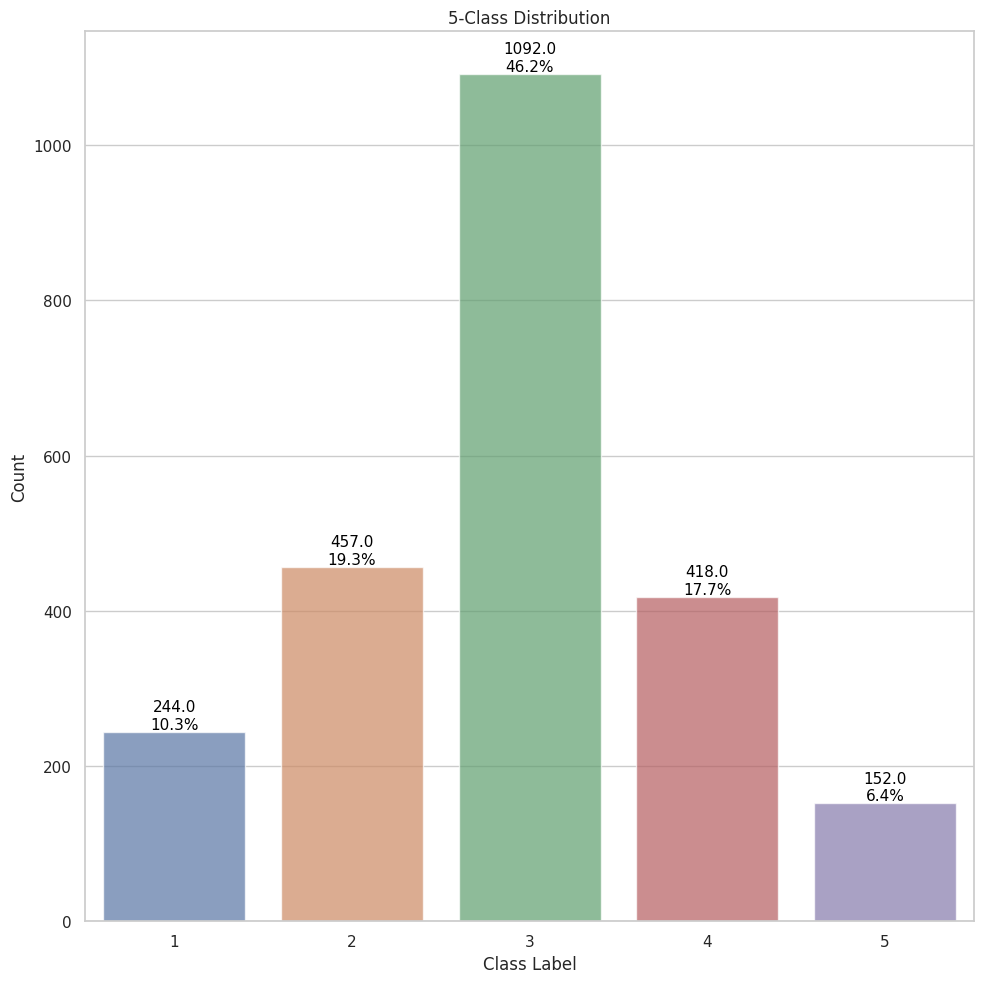

In [ ]:
# print and plot the 5-class distribution with counts and percentages
classes, counts = np.unique(y_full, return_counts=True)
total = y_full.shape[0]
print('5-class distribution:')
for cls, cnt in zip(classes, counts):
    pct = cnt / total * 100
    print(f'  class {cls}: {cnt} ({pct:.2f}%)')

sns.set(style='whitegrid')
plt.figure(figsize=(10,10))
ax = sns.countplot(x=y_full, palette='deep', alpha=0.7)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}\n{height/total*100:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=11, color='black')
ax.set_title('5-Class Distribution')
ax.set_xlabel('Class Label')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

Binary distribution:
  benign (0): 1793 (75.88%)
  malignant (1): 570 (24.12%)


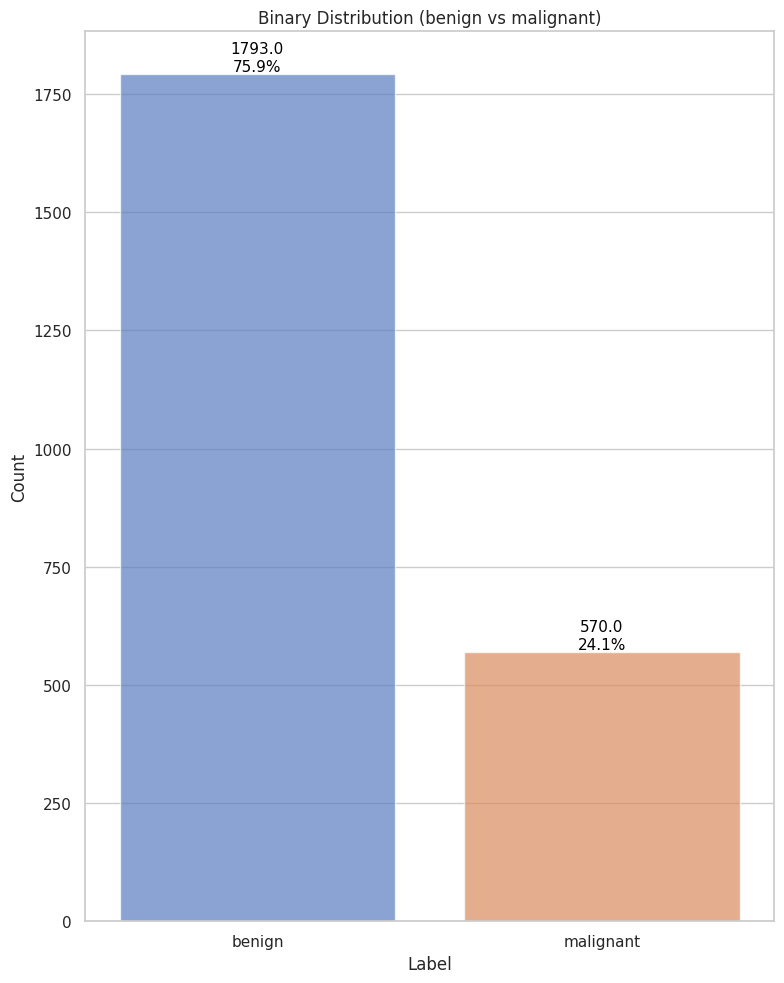

In [ ]:
# map to binary labels, then print and plot with counts and percentages
y_bin = np.where(y_full >= 4, 1, 0)
uniq, cnts = np.unique(y_bin, return_counts=True)
total_bin = y_bin.shape[0]
print('Binary distribution:')
print(f'  benign (0): {cnts[uniq.tolist().index(0)]} ({cnts[uniq.tolist().index(0)]/total_bin*100:.2f}%)')
print(f'  malignant (1): {cnts[uniq.tolist().index(1)]} ({cnts[uniq.tolist().index(1)]/total_bin*100:.2f}%)')

plt.figure(figsize=(8,10))
ax2 = sns.countplot(x=y_bin, palette='muted', alpha=0.7)
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}\n{height/total_bin*100:.1f}%',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=11, color='black')
ax2.set_title('Binary Distribution (benign vs malignant)')
ax2.set_xlabel('Label')
ax2.set_xticks([0,1])
ax2.set_xticklabels(['benign','malignant'])
ax2.set_ylabel('Count')
plt.tight_layout()
plt.show()

## Noise Estimation

Assuming coherence between images belonging to the dataset, determining whether a general noise removal step is necessary

Image shape: (512, 512), intensity range: -1000.0 to 3000.0 HU


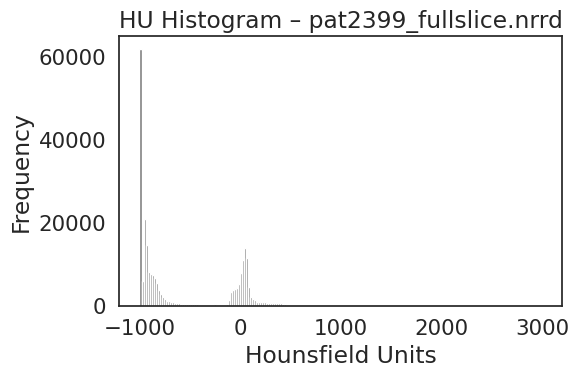

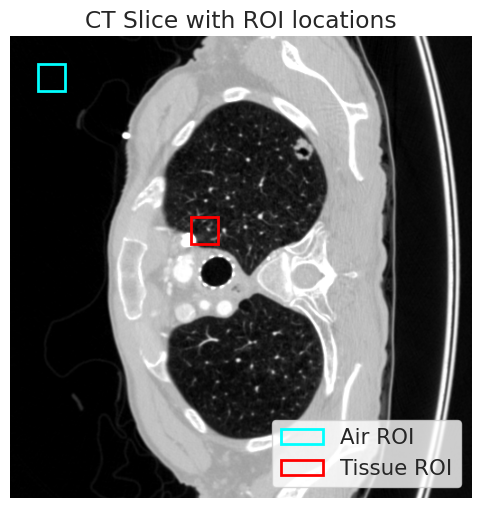

ROI (Air): mean -997.0 HU, σ 4.2 HU
ROI (Tissue): mean -555.3 HU, σ 785.1 HU


In [ ]:
img_path = "Train/pat2399_fullslice.nrrd"

# Load image
img = sitk.ReadImage(img_path)
arr = sitk.GetArrayFromImage(img).astype(np.float32)

# Intensity range
print(f"Image shape: {arr.shape}, intensity range: {arr.min()} to {arr.max()} HU")

# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(arr.flatten(), bins=200, color='gray')
plt.title("HU Histogram – pat2399_fullslice.nrrd")
plt.xlabel("Hounsfield Units")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot image with ROI locations
plt.figure(figsize=(6,6))
plt.imshow(arr, cmap='gray', vmin=-1000, vmax=400)
plt.title("CT Slice with ROI locations")
plt.gca().add_patch(plt.Rectangle((30, 30), 30, 30, edgecolor='cyan', fill=False, lw=2, label='Air ROI'))
plt.gca().add_patch(plt.Rectangle((200, 200), 30, 30, edgecolor='red', fill=False, lw=2, label='Tissue ROI'))
plt.legend(loc='lower right')
plt.axis('off')
plt.show()

# Re-calculate noise
def measure_roi_noise(arr, y0, x0, h, w):
    roi = arr[y0:y0+h, x0:x0+w]
    mean = np.mean(roi)
    std = np.std(roi)
    return mean, std

air_mean, air_std = measure_roi_noise(arr, 30, 30, 30, 30)
tis_mean, tis_std = measure_roi_noise(arr, 200, 200, 30, 30)

print(f"ROI (Air): mean {air_mean:.1f} HU, σ {air_std:.1f} HU")
print(f"ROI (Tissue): mean {tis_mean:.1f} HU, σ {tis_std:.1f} HU")

Very low noise in air and physiological variance within tissue, hence no explicit denoising filter is required. Applying one might cause relevant information loss

### Laplacian Variance Analysis

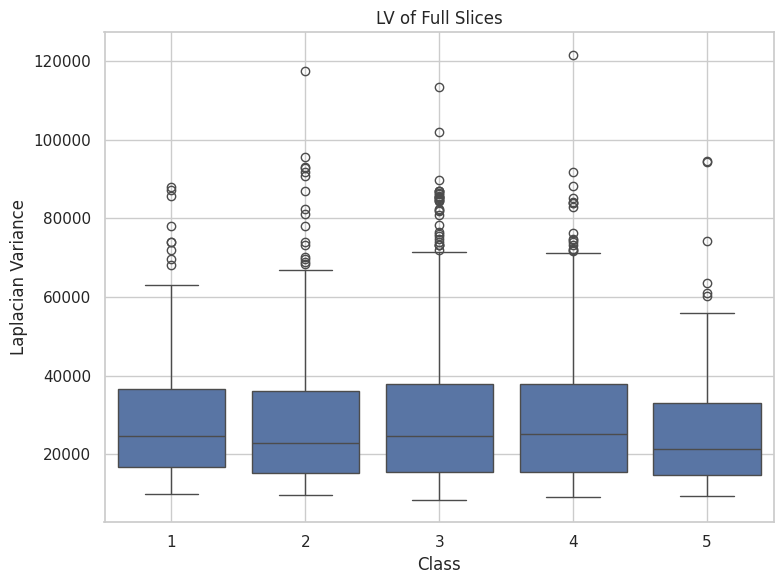

Number of noisy images by Laplacian Variance percentile:
 Percentile  Noisy Full Slices  Noisy Nodule Slices
         99                 24                   24
         98                 48                   48
         97                 71                   71
         96                 95                   95
         95                119                  119
         94                142                  142
         93                166                  166
         92                189                  189
         91                213                  213
         90                237                  237


Percentile  Noisy Full Slices  Noisy Nodule Slices
0          99                 24                   24
1          98                 48                   48
2          97                 71                   71
3          96                 95                   95
4          95                119                  119
5          94                142                  142
6          93                166                  166
7          92                189                  189
8          91                213                  213
9          90                237                  237

In [ ]:
import cv2

def compute_laplacian_variance(images):
    variances = []
    for img in images:
        img_gray = img.squeeze()  # Remove channel dim if needed
        if img_gray.dtype != np.uint8:
            img_gray = (img_gray * 255).astype(np.uint8)
        lv = cv2.Laplacian(img_gray, cv2.CV_64F).var()
        variances.append(lv)
    return np.array(variances)

def summarize_laplacian_percentiles(variances, percentiles=[99, 98, 97, 96, 95, 94, 93, 92, 91, 90]):
    summary = {p: np.sum(variances >= np.percentile(variances, p)) for p in percentiles}
    return pd.DataFrame.from_dict(summary, orient='index', columns=['Noisy Count'])

def plot_laplacian_boxplot(variances, labels, title):
    df = pd.DataFrame({'Laplacian Variance': variances, 'Class': labels})
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Class', y='Laplacian Variance', data=df)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Compute LV
lv_full = compute_laplacian_variance(X_full)
lv_nod = compute_laplacian_variance(X_nod)

# Plot boxplot
plot_laplacian_boxplot(lv_full, y_full, "LV of Full Slices")

# Build table
def draw_noise_table(full_lv, nod_lv):
    percentiles = [99, 98, 97, 96, 95, 94, 93, 92, 91, 90]
    full_counts = [np.sum(full_lv >= np.percentile(full_lv, p)) for p in percentiles]
    nod_counts = [np.sum(nod_lv >= np.percentile(nod_lv, p)) for p in percentiles]
    df = pd.DataFrame({
        'Percentile': percentiles,
        'Noisy Full Slices': full_counts,
        'Noisy Nodule Slices': nod_counts
    })
    print("Number of noisy images by Laplacian Variance percentile:")
    print(df.to_string(index=False))
    return df

draw_noise_table(lv_full, lv_nod)

To assess image quality and detect noisy samples, we computed the Laplacian Variance (LV) for each image. The LV serves as a measure of sharpness—higher values often indicate excessive noise or artifacts. As visualized in the boxplot for full-slice images, most classes exhibit a similar spread of variance, with some extreme outliers. Notably, Classes 3 and 4 tend to have higher variance ranges, while Class 5 shows a tighter spread but still contains significant noise outliers.

To quantify noise, we summarized the number of images above certain LV percentiles. For instance, the top 1% noisiest images correspond to 24 samples in both full and nodule slices, while the top 10% include 237 samples. Although it is tempting to remove noisy images to improve model performance, this must be done cautiously—especially with underrepresented classes—since some outliers may contain valuable pathological variation. Therefore, we suggest flagging rather than removing these samples or optionally excluding only the top 1–2% of noisiest slices.

# Data Preprocessing

Understanding how the data changes following literature best practices. The CT slices already have a uniform 1 mm × 1 mm in‐plane spacing and identity direction cosines, so no resampling is required to standardize voxel dimensions.

Quick random visual inspection to see what we are working with

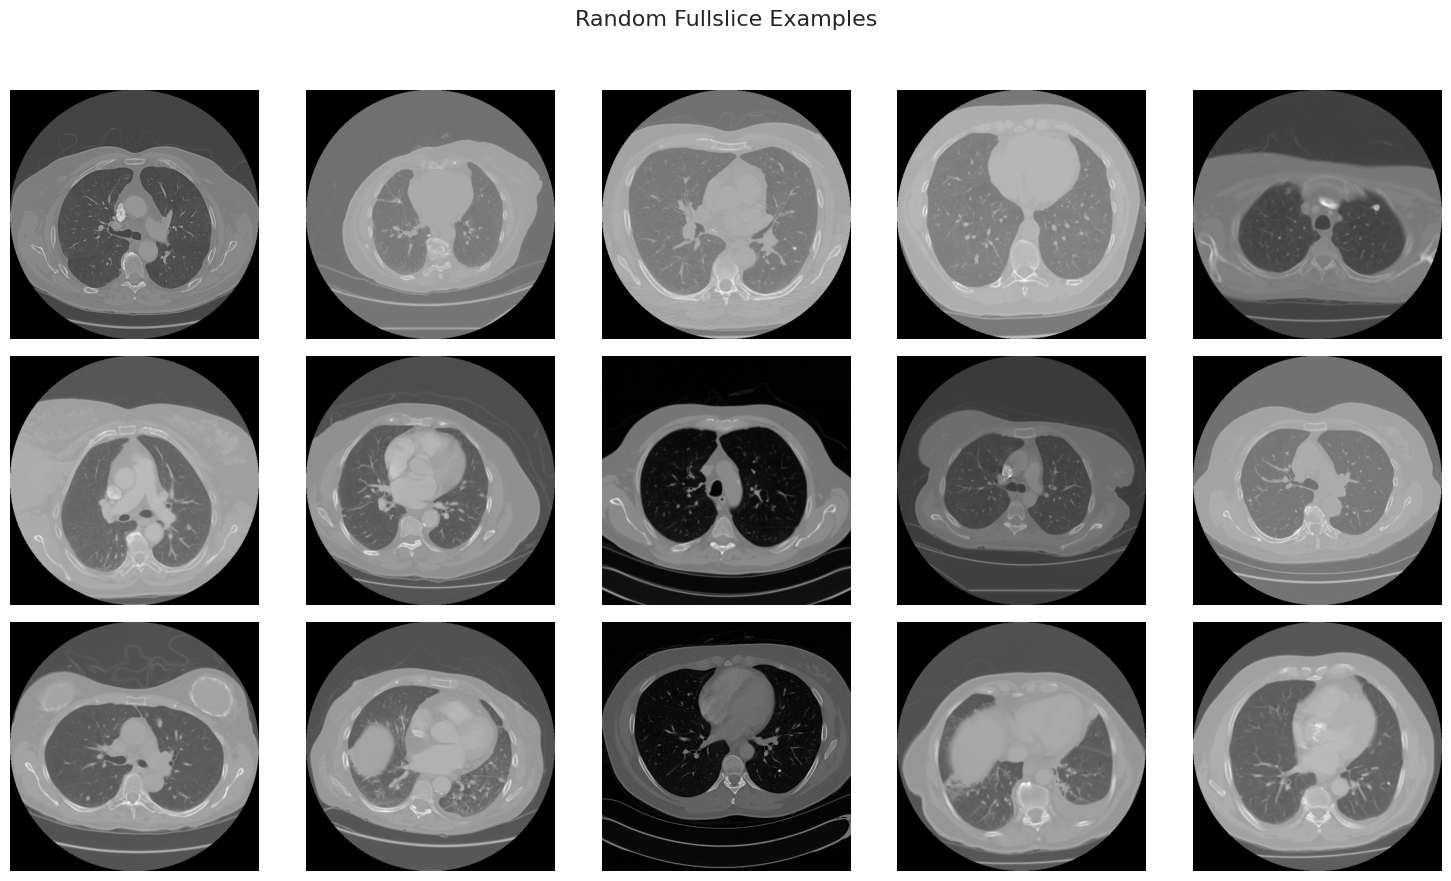

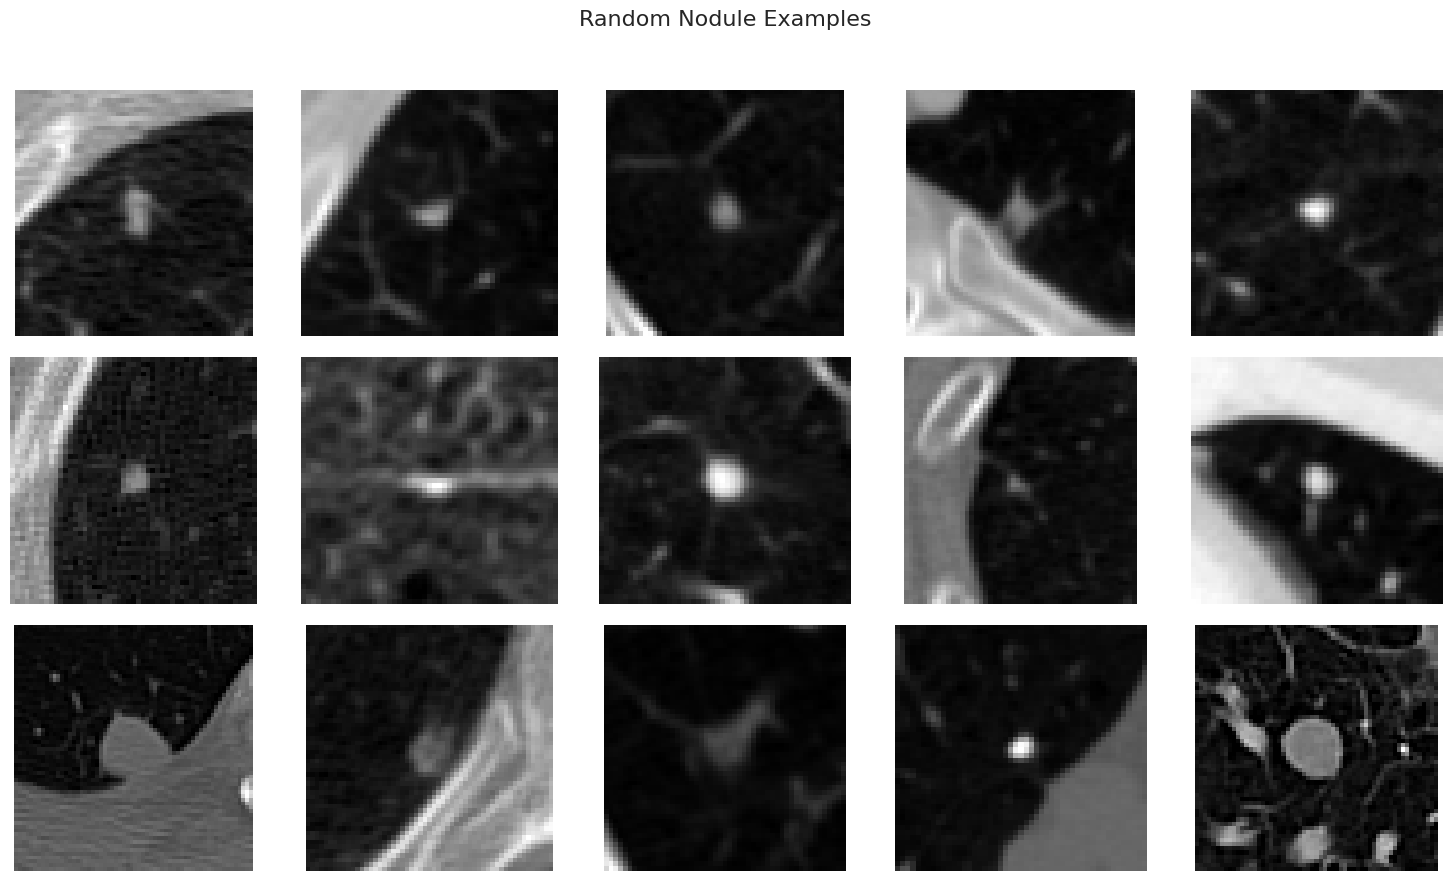

In [ ]:
# Load metadata
df = pd.read_excel("dataset_lung.xlsx")
train_dir = "Train"

# Sample 15 random fullslice filenames
fs_samples = random.sample(df["Full_slice"].tolist(), 15)
# Sample 15 random nodule filenames
nd_samples = random.sample(df["Nodule"].tolist(), 15)

# --- Display 3×5 grid of Fullslice images ---
plt.figure(figsize=(15, 9))
for i, fname in enumerate(fs_samples):
    img, _ = nrrd.read(os.path.join(train_dir, fname))
    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.suptitle("Random Fullslice Examples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Display 3×5 grid of Nodule images ---
plt.figure(figsize=(15, 9))
for i, fname in enumerate(nd_samples):
    img, _ = nrrd.read(os.path.join(train_dir, fname))
    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.suptitle("Random Nodule Examples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

We notice some contrast differences, it might be due to the amount of the rescaling that happens when python visualized stuff within [0 255]. Maybe clipping wrt literature values will help

In [ ]:
# Sample 1 patient per class
df = pd.read_excel("dataset_lung.xlsx")
sample_df = df.groupby("TumorClass", group_keys=False).apply(lambda g: g.sample(1)).reset_index(drop=True)

train_dir = "Train"
full_paths = [os.path.join(train_dir, fn) for fn in sample_df["Full_slice"]]
nod_paths  = [os.path.join(train_dir, fn) for fn in sample_df["Nodule"]]
labels     = sample_df["TumorClass"].astype(str).tolist()

# Read original images
orig_full = [nrrd.read(p)[0] for p in full_paths]
orig_nod  = [nrrd.read(p)[0] for p in nod_paths]

## HU Clipping

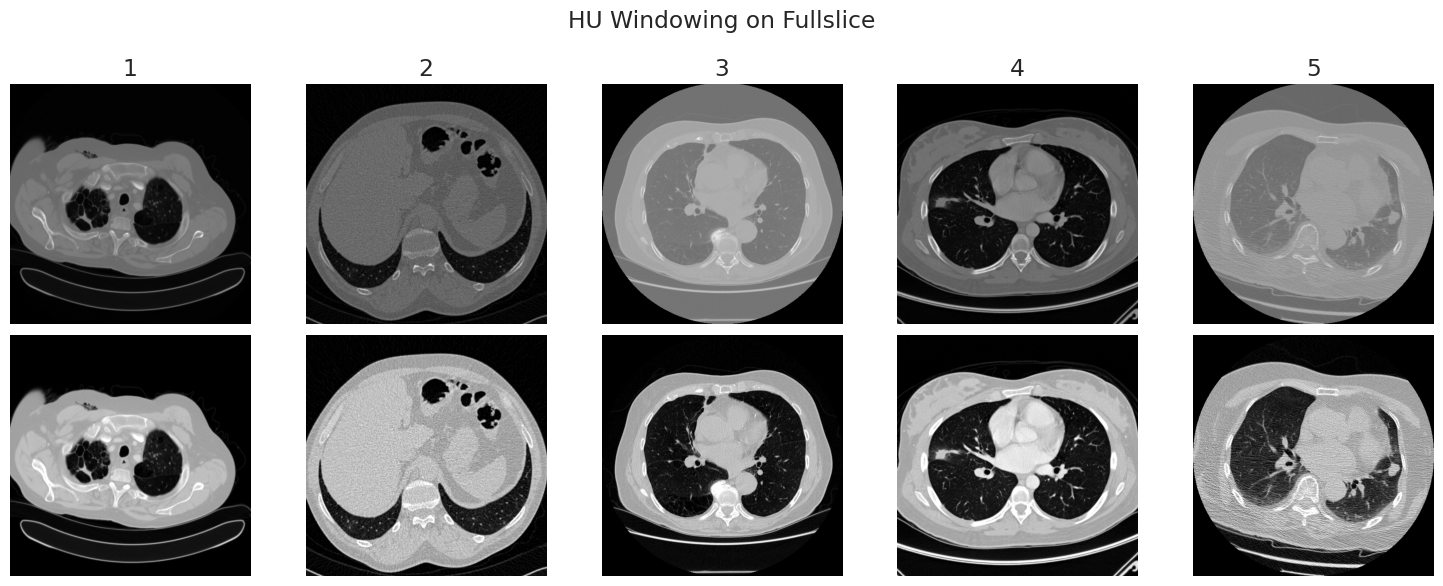

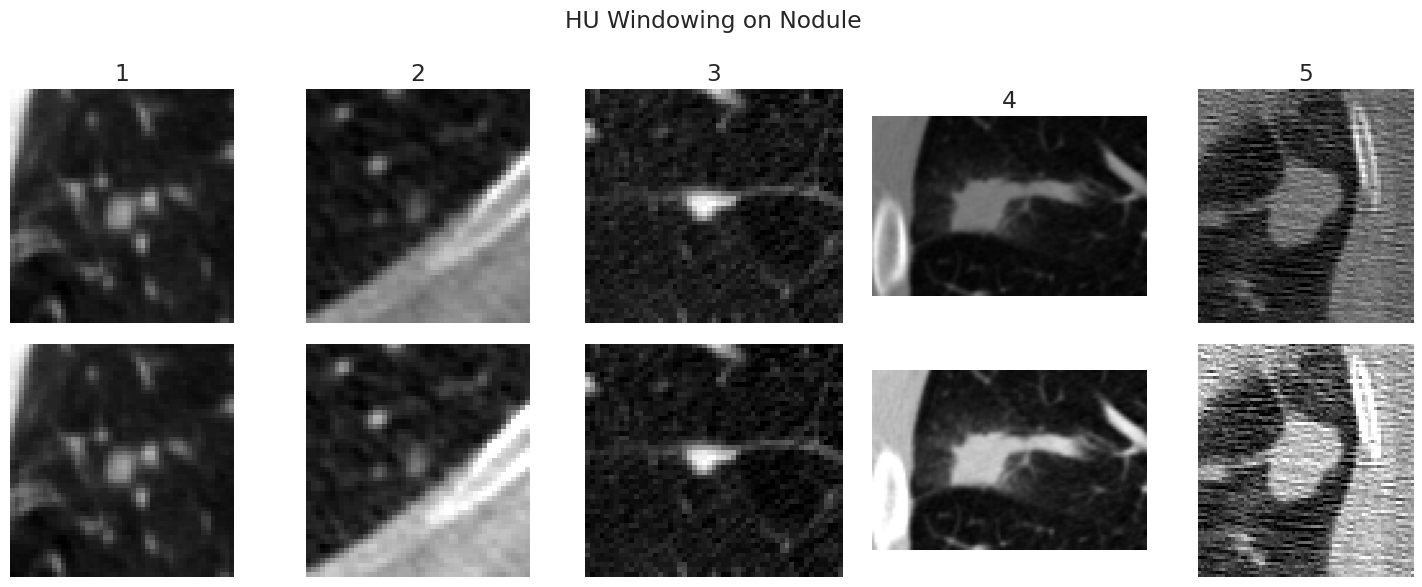

In [ ]:
# Apply HU windowing [-1000, 400]
win_full = [np.clip(img, -1000, 400) for img in orig_full]
win_nod  = [np.clip(img, -1000, 400) for img in orig_nod]

# Visualize Fullslice before/after
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1);   plt.imshow(orig_full[i], cmap="gray"); plt.title(labels[i]); plt.axis("off")
    plt.subplot(2,5,i+6);   plt.imshow(win_full[i],  cmap="gray");                    plt.axis("off")
plt.suptitle("HU Windowing on Fullslice"); plt.tight_layout(); plt.show()

# Visualize Nodule before/after
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1);   plt.imshow(orig_nod[i], cmap="gray");  plt.title(labels[i]); plt.axis("off")
    plt.subplot(2,5,i+6);   plt.imshow(win_nod[i],  cmap="gray");                       plt.axis("off")
plt.suptitle("HU Windowing on Nodule"); plt.tight_layout(); plt.show()

... and in fact it does help.

Noticing some noise is even getting exacerbated.. Gotta find literature on CT noise type so we can try to filter it out.

### Lung Segmentation through Clipping

Trying thresholding based on literature HU values, namely trying to narrow down the HU window even more

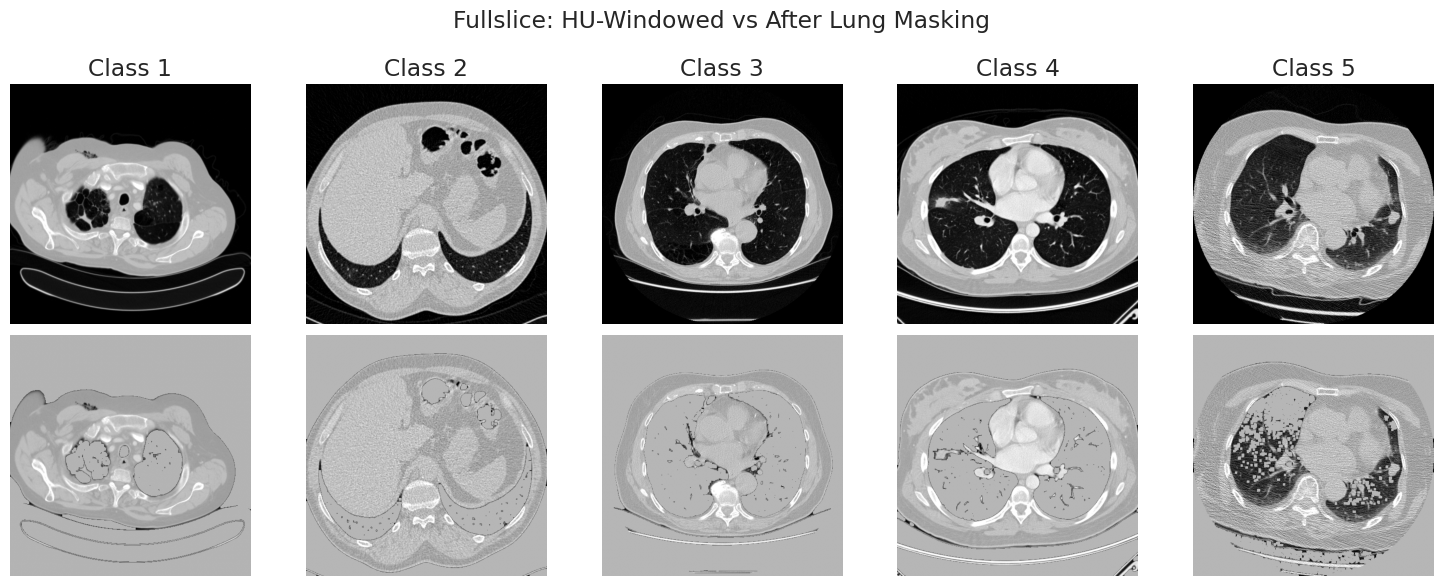

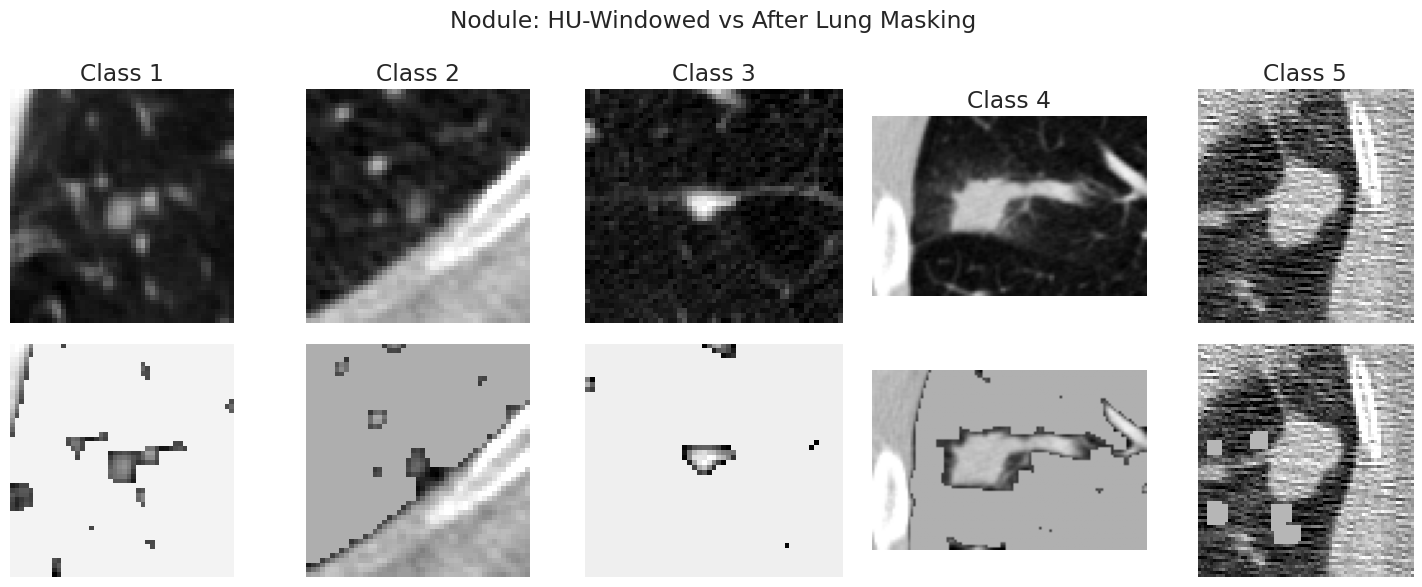

In [ ]:
# Use binary closing after thresholding > -600 HU to simulate lung mask
fp = np.ones((5,5), bool)
mask_full = [morphology.binary_closing(img > -600, footprint=fp) for img in win_full]
mask_nod  = [morphology.binary_closing(img > -600, footprint=fp) for img in win_nod]

# Apply mask
seg_full = [win_full[i] * mask_full[i] for i in range(5)]
seg_nod  = [win_nod[i]  * mask_nod[i]  for i in range(5)]

# Visualize Fullslice: Windowed vs Masked
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1);   plt.imshow(win_full[i], cmap="gray");  plt.title(f"Class {labels[i]}"); plt.axis("off")
    plt.subplot(2,5,i+6);   plt.imshow(seg_full[i], cmap="gray");  plt.axis("off")
plt.suptitle("Fullslice: HU-Windowed vs After Lung Masking"); plt.tight_layout(); plt.show()

# Visualize Nodule: Windowed vs Masked
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1);   plt.imshow(win_nod[i], cmap="gray");   plt.title(f"Class {labels[i]}"); plt.axis("off")
    plt.subplot(2,5,i+6);   plt.imshow(seg_nod[i], cmap="gray");   plt.axis("off")
plt.suptitle("Nodule: HU-Windowed vs After Lung Masking"); plt.tight_layout(); plt.show()

Noticing it might remove information and performs badly with noise, hence we decided to stick to a more conservative clipping on HU values, namely [-1000,400].

## Padding and Resizing to 224x224

Gotta resize to be coherent with standard model input sizes

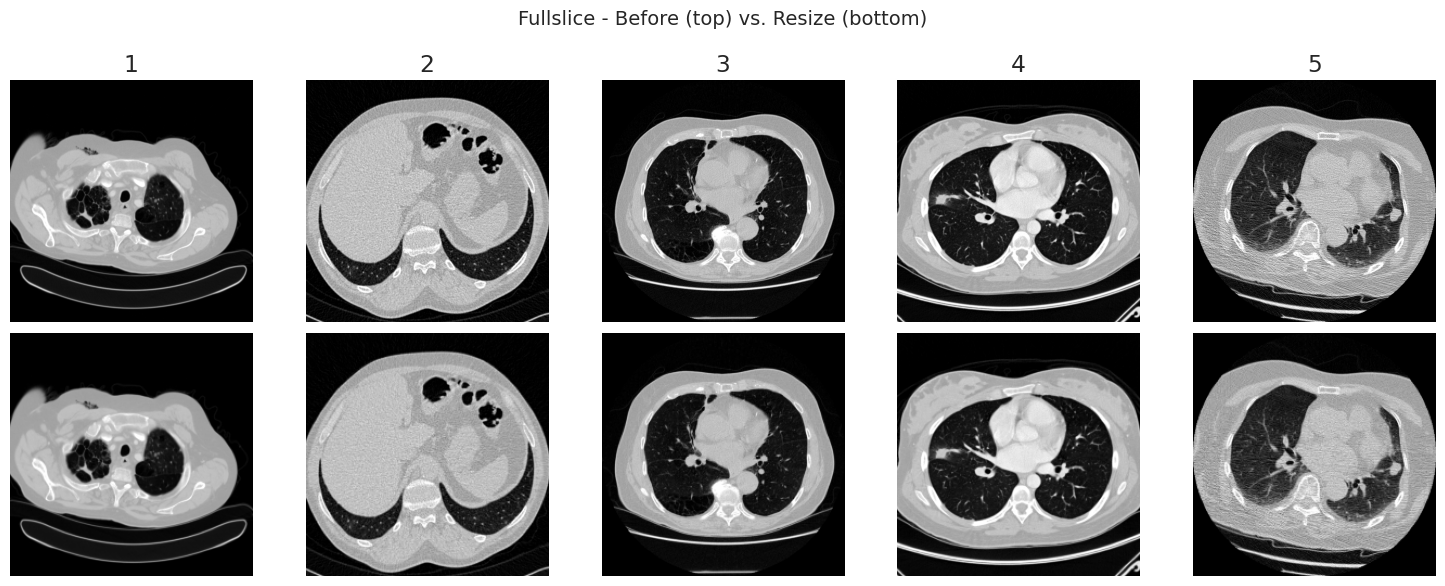

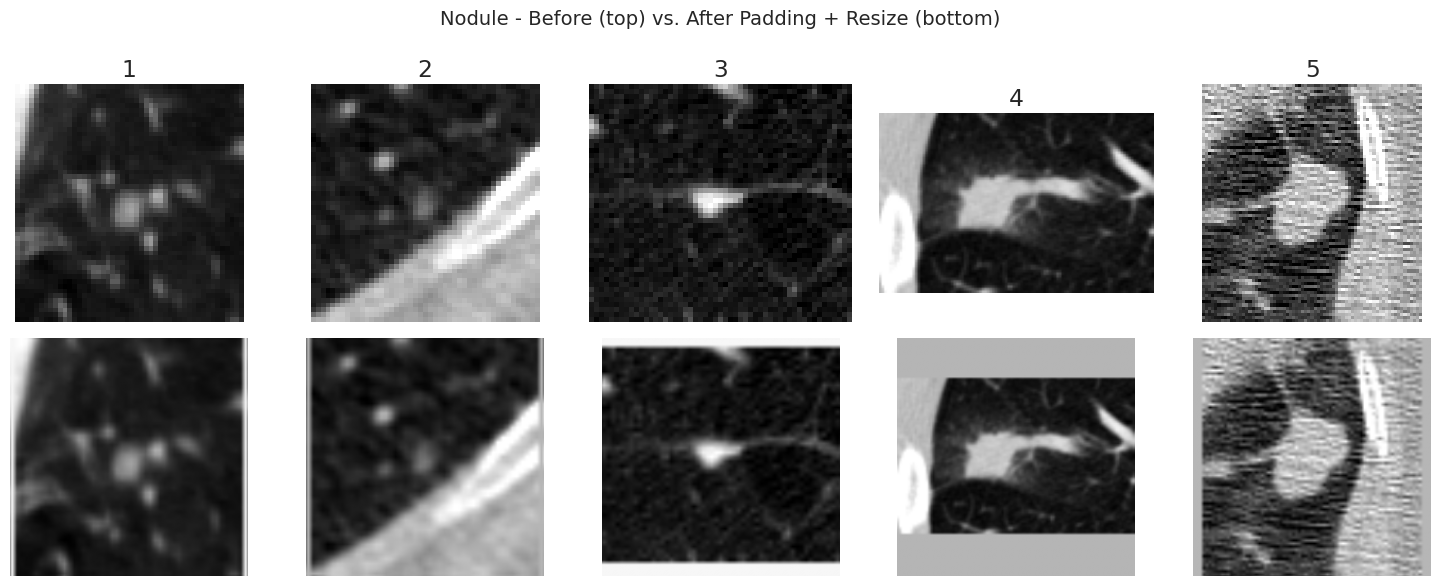

In [ ]:
# Pad to square
def pad_to_square(img):
    h, w = img.shape
    pad_y = max(w - h, 0)
    pad_x = max(h - w, 0)
    padded = np.pad(img,
                    ((pad_y // 2, pad_y - pad_y // 2),
                     (pad_x // 2, pad_x - pad_x // 2)),
                    mode='constant', constant_values=0)
    return padded

# Apply padding and resize
pad_full = [pad_to_square(img) for img in win_full]
pad_nod  = [pad_to_square(img) for img in win_nod]

res_full = [resize(img, (224, 224), mode='reflect', preserve_range=True) for img in pad_full]
res_nod  = [resize(img, (224, 224), mode='reflect', preserve_range=True) for img in pad_nod]

# Plot Fullslice before/after padding + resize
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1);   plt.imshow(win_full[i], cmap="gray"); plt.title(labels[i]); plt.axis("off")
    plt.subplot(2,5,i+6);   plt.imshow(res_full[i],  cmap="gray");                    plt.axis("off")
plt.suptitle("Fullslice - Before (top) vs. Resize (bottom)", fontsize=14)
plt.tight_layout(); plt.show()

# Plot Nodule before/after padding + resize
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1);   plt.imshow(win_nod[i], cmap="gray");  plt.title(labels[i]); plt.axis("off")
    plt.subplot(2,5,i+6);   plt.imshow(res_nod[i],  cmap="gray");                       plt.axis("off")
plt.suptitle("Nodule - Before (top) vs. After Padding + Resize (bottom)", fontsize=14)
plt.tight_layout(); plt.show()

## Z-Score Normalization

Normalizing at the end for good practice: we want our input values not to affect weight update

Fullslice Statistics:
Before z-score: mean = -499.57, std = 472.19
After  z-score: mean = -0.00, std = 1.00

Nodule Statistics:
Before z-score: mean = -621.44, std = 374.17
After  z-score: mean = 0.00, std = 1.00


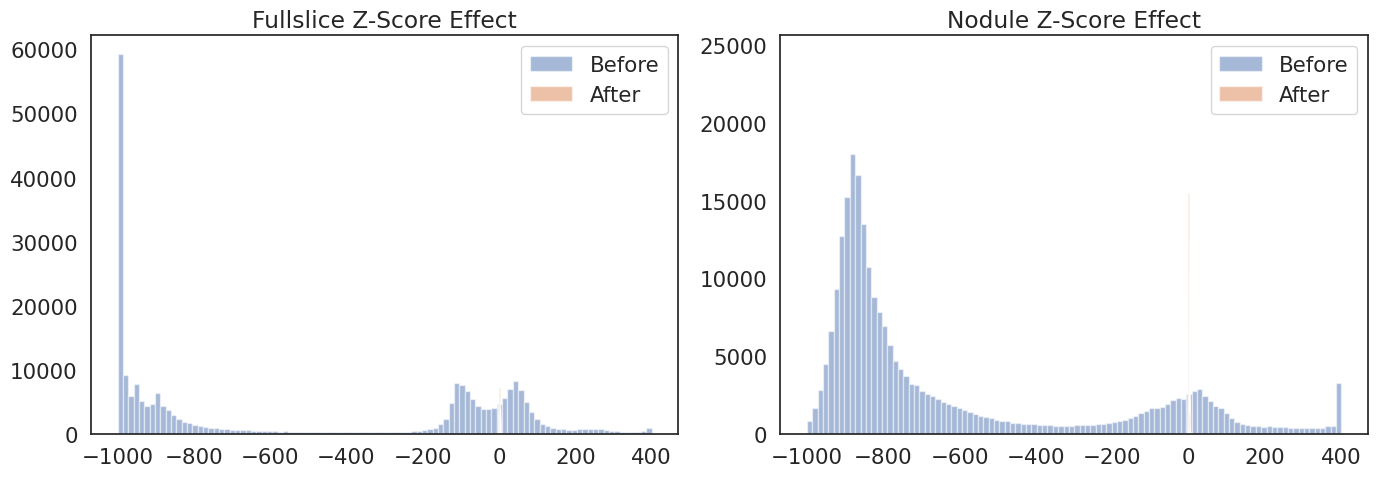

In [ ]:
# Z-score normalization: (x - μ) / σ
norm_full = [(img - np.mean(img)) / (np.std(img) + 1e-8) for img in res_full]
norm_nod  = [(img - np.mean(img)) / (np.std(img) + 1e-8) for img in res_nod]

# Stack all pixels together
all_full_before = np.concatenate([img.ravel() for img in res_full])
all_full_after  = np.concatenate([img.ravel() for img in norm_full])
all_nod_before  = np.concatenate([img.ravel() for img in res_nod])
all_nod_after   = np.concatenate([img.ravel() for img in norm_nod])

# Print global stats
print("Fullslice Statistics:")
print(f"Before z-score: mean = {all_full_before.mean():.2f}, std = {all_full_before.std():.2f}")
print(f"After  z-score: mean = {all_full_after.mean():.2f}, std = {all_full_after.std():.2f}\n")

print("Nodule Statistics:")
print(f"Before z-score: mean = {all_nod_before.mean():.2f}, std = {all_nod_before.std():.2f}")
print(f"After  z-score: mean = {all_nod_after.mean():.2f}, std = {all_nod_after.std():.2f}")

# Plot histograms
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(all_full_before, bins=100, alpha=0.5, label="Before")
plt.hist(all_full_after,  bins=100, alpha=0.5, label="After")
plt.title("Fullslice Z-Score Effect"); plt.legend()

plt.subplot(1,2,2)
plt.hist(all_nod_before, bins=100, alpha=0.5, label="Before")
plt.hist(all_nod_after,  bins=100, alpha=0.5, label="After")
plt.title("Nodule Z-Score Effect"); plt.legend()

plt.tight_layout(); plt.show()

# Preprocessed Dataset Creation

Creating the two datasets that will be employed to perform exploratory dataset analysis, outlier detection, and possible class imbalance management.

In [ ]:
import os
import pandas as pd
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
from skimage.transform import resize

# Parameters
WINDOW_MIN, WINDOW_MAX = -1000.0, 400.0
TARGET_SIZE = 224  # pixels

# Read metadata
df = pd.read_excel("dataset_lung.xlsx")

# Containers
full_images, full_labels = [], []
nod_images,  nod_labels  = [], []

from skimage.transform import resize

def preprocess_slice(path):
    img = sitk.ReadImage(path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)

    # 1) HU windowing
    arr = np.clip(arr, WINDOW_MIN, WINDOW_MAX)

    # 2) pad to square
    h, w = arr.shape
    pad_y = max(w - h, 0)
    pad_x = max(h - w, 0)
    arr = np.pad(arr,
                 ((pad_y // 2, pad_y - pad_y // 2),
                  (pad_x // 2, pad_x - pad_x // 2)),
                 mode='constant', constant_values=0)

    # 3) resize to TARGET_SIZE
    arr = resize(arr, (TARGET_SIZE, TARGET_SIZE), preserve_range=True, mode='reflect', anti_aliasing=True)

    # 4) z-score normalization (per image)
    mean = arr.mean()
    std  = arr.std() if arr.std() > 0 else 1.0  # avoid division by zero
    arr = (arr - mean) / std

    return arr.astype(np.float32)

# Process all rows
for idx, row in tqdm(df.iterrows(), total=len(df)):
    label = row['TumorClass']

    # Full slice
    fs_path = os.path.join("Train", row['Full_slice'])
    fs_img  = preprocess_slice(fs_path)
    full_images.append(fs_img)
    full_labels.append(label)

    # Nodule
    n_path = os.path.join("Train", row['Nodule'])
    n_img  = preprocess_slice(n_path)
    nod_images.append(n_img)
    nod_labels.append(label)

# Convert and save
full_X = np.stack(full_images)
full_y = np.array(full_labels)
nod_X  = np.stack(nod_images)
nod_y  = np.array(nod_labels)

np.savez_compressed("fullslice_dataset.npz", X=full_X, y=full_y)
np.savez_compressed("nodule_dataset.npz",  X=nod_X,  y=nod_y)

100%|██████████| 2363/2363 [43:59<00:00,  1.12s/it]
